# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2020-10-14

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-10-14.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing daily reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 109 to 79014
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      216 non-null    datetime64[ns]
 1   Day                 216 non-null    object        
 2   Week                216 non-null    int64         
 3   Daily_delta         216 non-null    int64         
 4   Total_reported      216 non-null    int64         
 5   Deceased            216 non-null    int64         
 6   Deceased_delta      216 non-null    int64         
 7   Hospital_admission  216 non-null    int64         
 8   Hospital_delta      216 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 16.9+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
75711,2020-10-05,Monday,41,351,14903,302,0,792,12
76078,2020-10-06,Tuesday,41,479,15382,302,0,800,8
76445,2020-10-07,Wednesday,41,464,15846,305,3,808,8
76812,2020-10-08,Thursday,41,445,16291,305,0,818,10
77179,2020-10-09,Friday,41,498,16789,307,2,828,10
77546,2020-10-10,Saturday,41,630,17419,307,0,830,2
77913,2020-10-11,Sunday,41,420,17839,309,2,834,4
78280,2020-10-12,Monday,42,590,18429,309,0,843,9
78647,2020-10-13,Tuesday,42,734,19163,311,2,859,16
79014,2020-10-14,Wednesday,42,639,19802,311,0,862,3


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
78647,2020-10-13,42,734,19163,16
79014,2020-10-14,42,639,19802,3
77546,2020-10-10,41,630,17419,2
78280,2020-10-12,42,590,18429,9
77179,2020-10-09,41,498,16789,10
76078,2020-10-06,41,479,15382,8
72775,2020-09-27,39,465,12018,5
76445,2020-10-07,41,464,15846,8
75344,2020-10-04,40,458,14552,8
76812,2020-10-08,41,445,16291,10


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot daily reported cases, by week

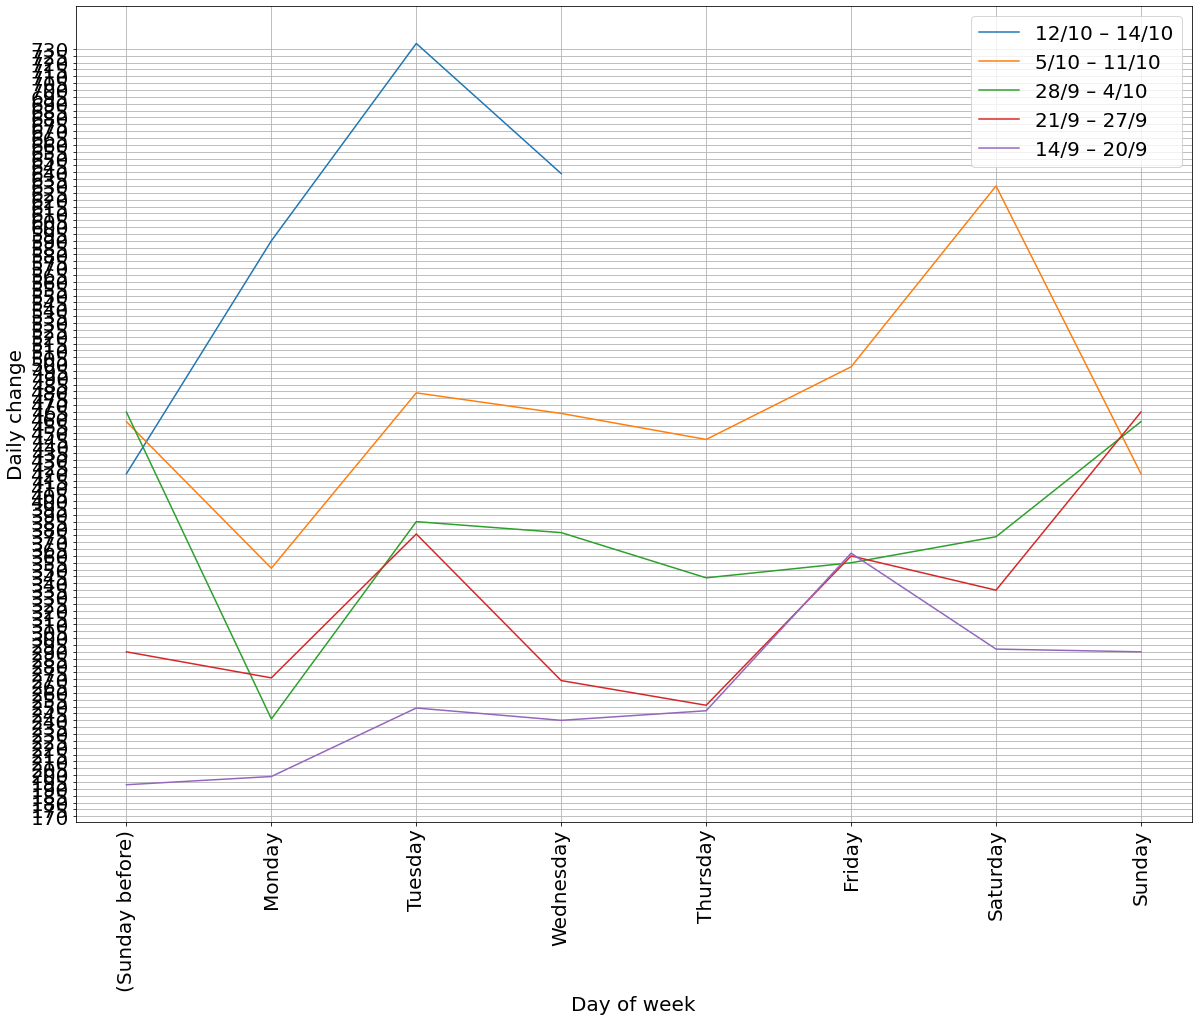

,Date_of_report,Week,Daily_delta,Total_reported
76812,2020-10-08,41,445,16291
77179,2020-10-09,41,498,16789
77546,2020-10-10,41,630,17419
77913,2020-10-11,41,420,17839
78280,2020-10-12,42,590,18429
78647,2020-10-13,42,734,19163
79014,2020-10-14,42,639,19802


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week reported cases

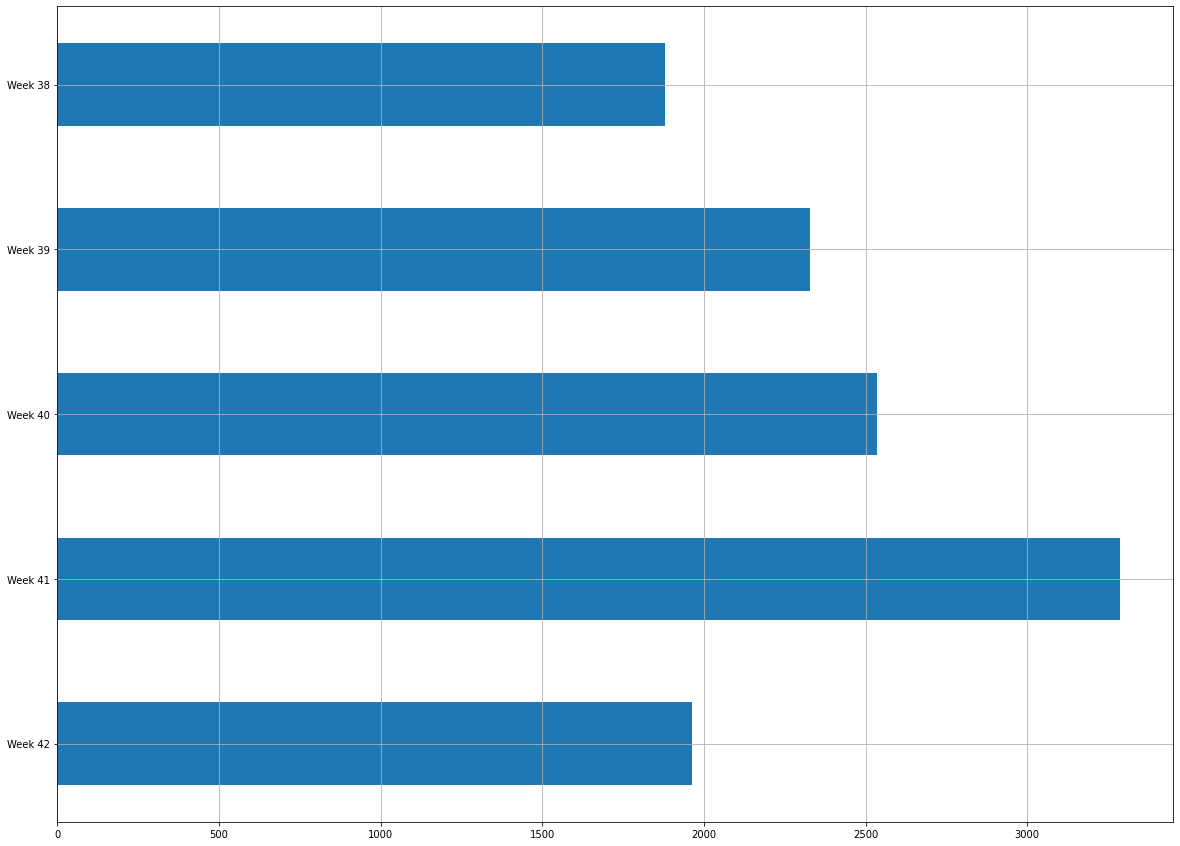

{'Week 38': 1879,
 'Week 39': 2327,
 'Week 40': 2534,
 'Week 41': 3287,
 'Week 42': 1963}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 30 days

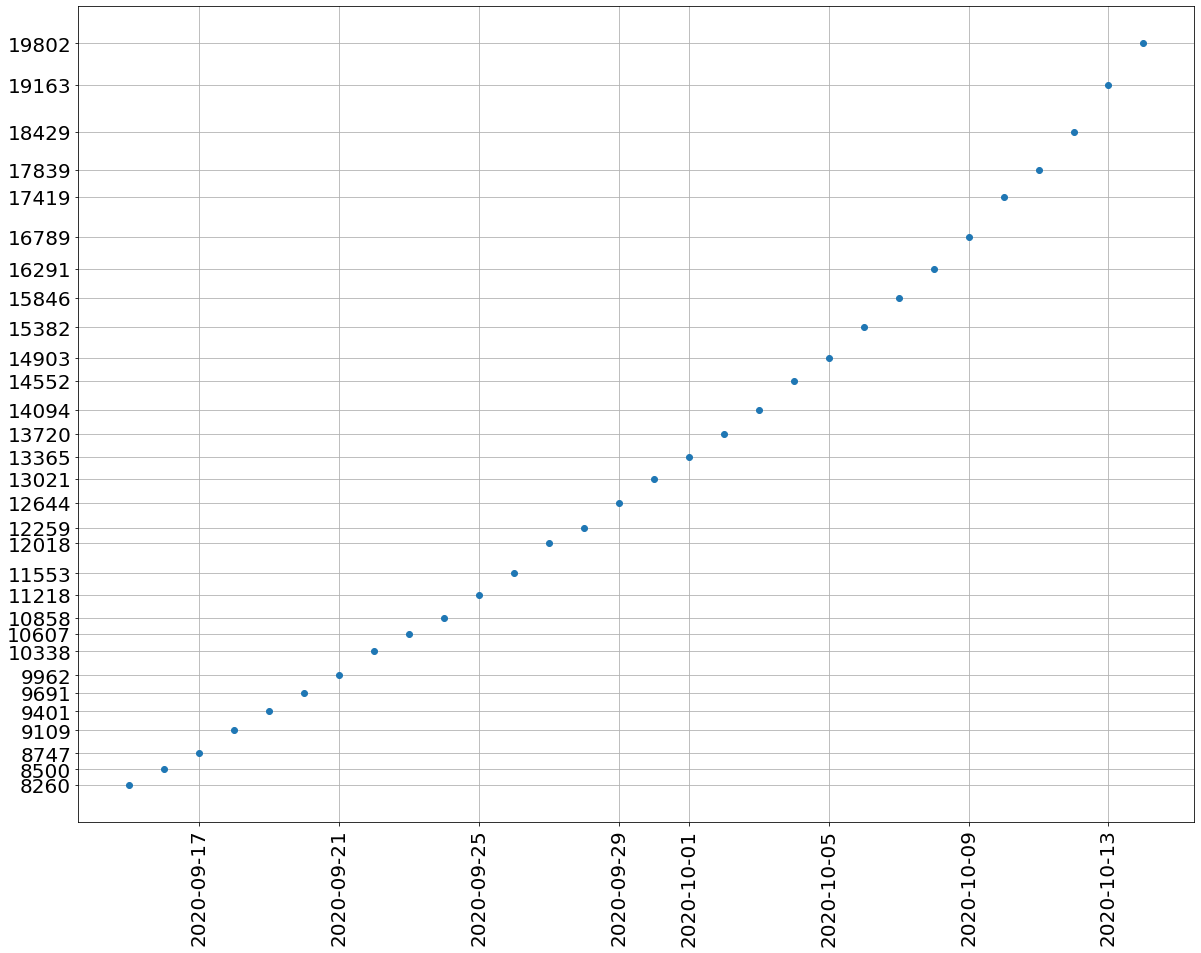

      Date_of_report  Total_reported
68371     2020-09-15            8260
68738     2020-09-16            8500
69105     2020-09-17            8747
69472     2020-09-18            9109
69839     2020-09-19            9401
70206     2020-09-20            9691
70573     2020-09-21            9962
70940     2020-09-22           10338
71307     2020-09-23           10607
71674     2020-09-24           10858
72041     2020-09-25           11218
72408     2020-09-26           11553
72775     2020-09-27           12018
73142     2020-09-28           12259
73509     2020-09-29           12644
73876     2020-09-30           13021
74243     2020-10-01           13365
74610     2020-10-02           13720
74977     2020-10-03           14094
75344     2020-10-04           14552
75711     2020-10-05           14903
76078     2020-10-06           15382
76445     2020-10-07           15846
76812     2020-10-08           16291
77179     2020-10-09           16789
77546     2020-10-10           17419
7

In [10]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

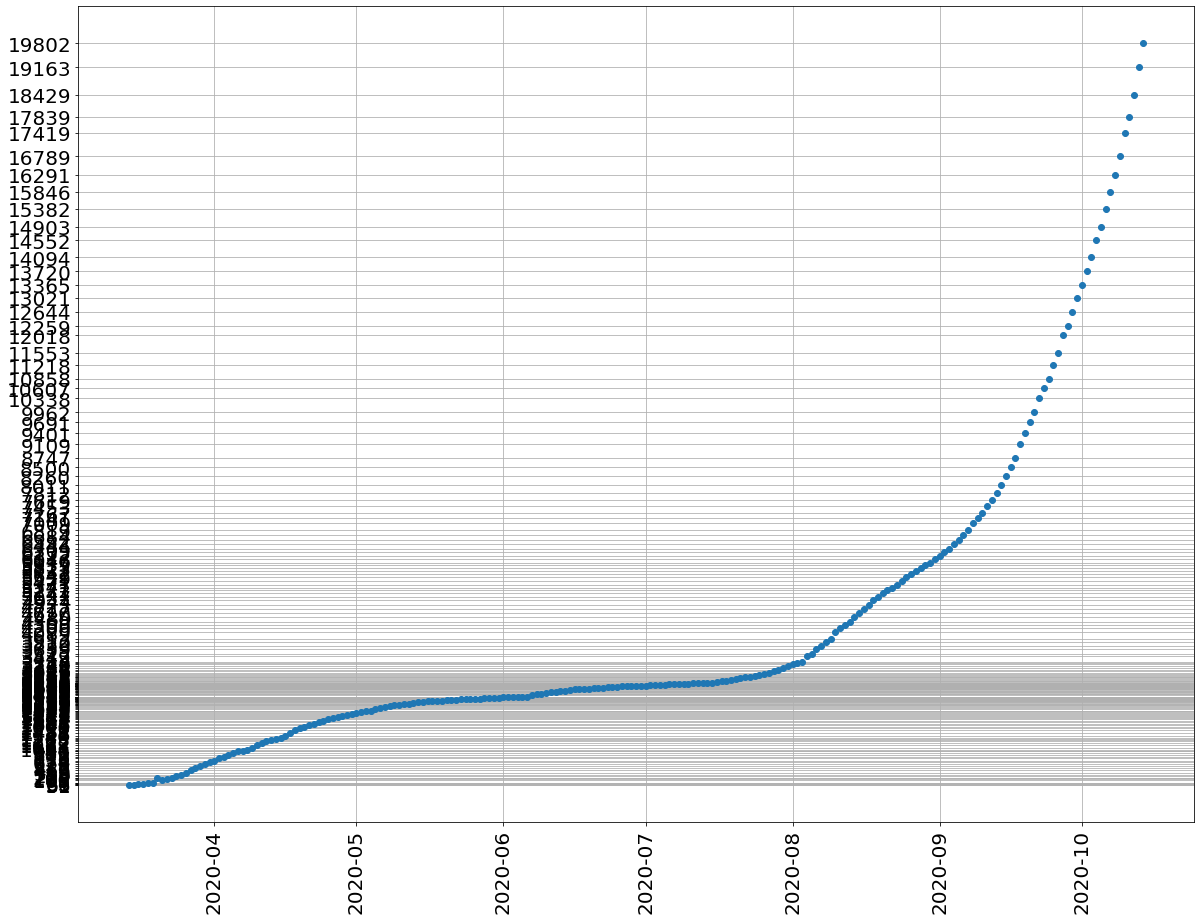

      Date_of_report  Total_reported
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
1944      2020-03-18              61
...              ...             ...
77546     2020-10-10           17419
77913     2020-10-11           17839
78280     2020-10-12           18429
78647     2020-10-13           19163
79014     2020-10-14           19802

[215 rows x 2 columns]


In [11]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Cumulative hospitalizations for last 30 days

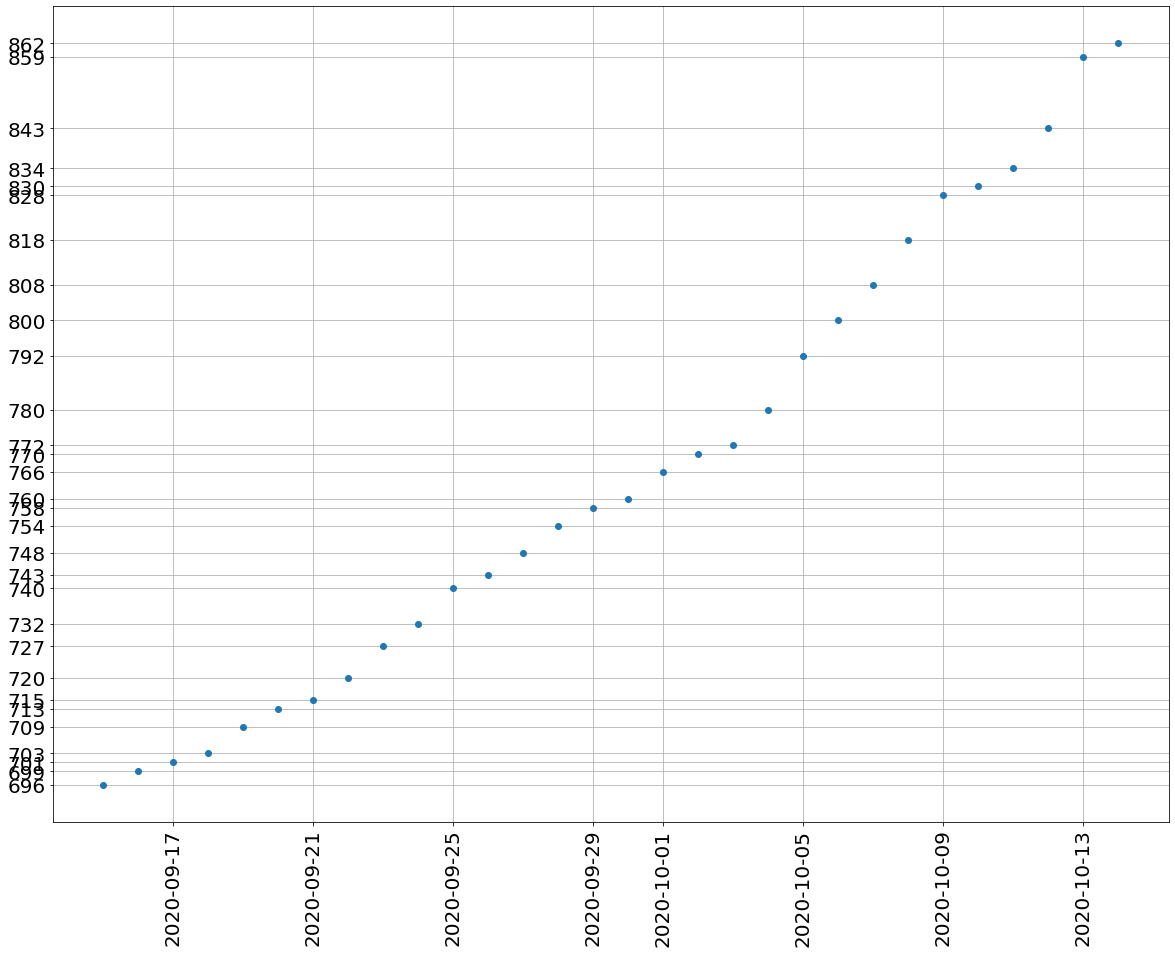

      Date_of_report  Hospital_admission
68371     2020-09-15                 696
68738     2020-09-16                 699
69105     2020-09-17                 701
69472     2020-09-18                 703
69839     2020-09-19                 709
70206     2020-09-20                 713
70573     2020-09-21                 715
70940     2020-09-22                 720
71307     2020-09-23                 727
71674     2020-09-24                 732
72041     2020-09-25                 740
72408     2020-09-26                 743
72775     2020-09-27                 748
73142     2020-09-28                 754
73509     2020-09-29                 758
73876     2020-09-30                 760
74243     2020-10-01                 766
74610     2020-10-02                 770
74977     2020-10-03                 772
75344     2020-10-04                 780
75711     2020-10-05                 792
76078     2020-10-06                 800
76445     2020-10-07                 808
76812     2020-1

In [12]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")

### Cumulative hospitalizations since beginning

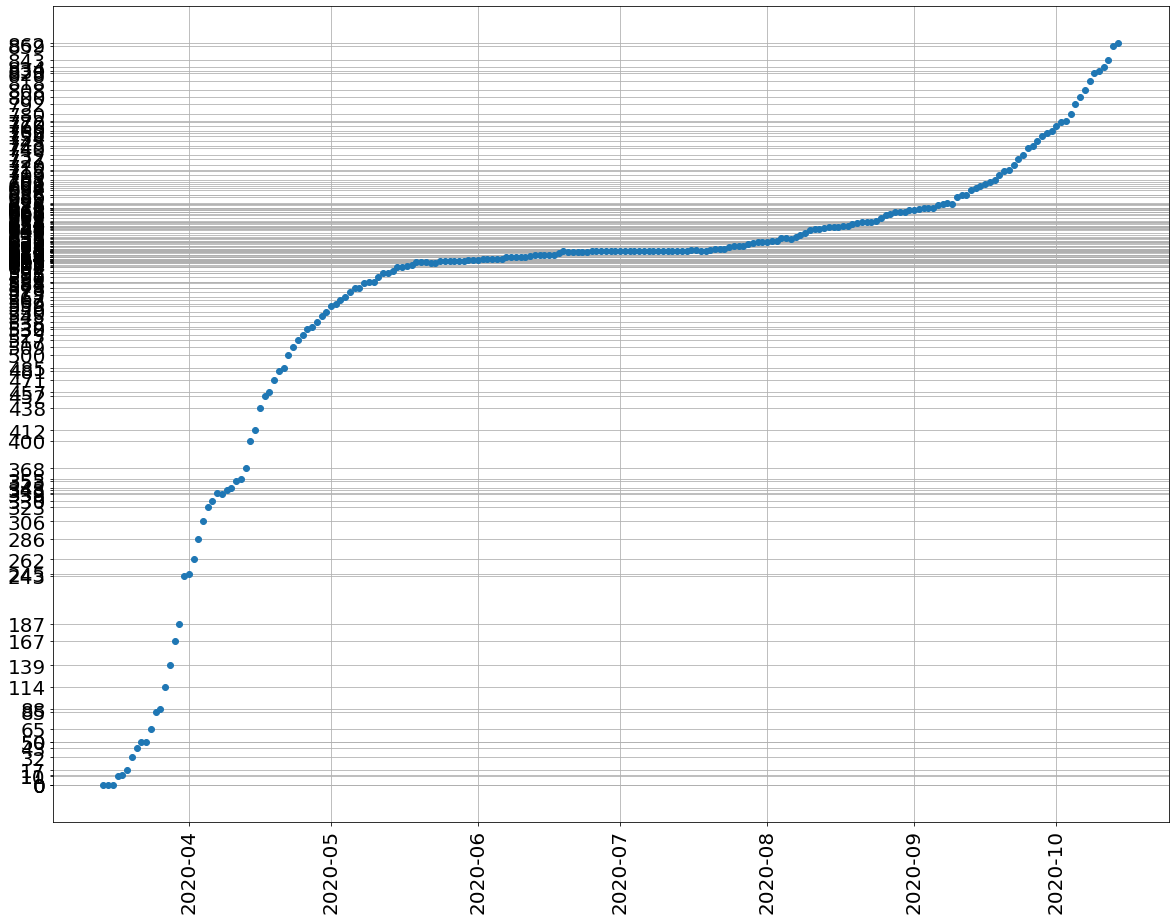

      Date_of_report  Hospital_admission
476       2020-03-14                   0
843       2020-03-15                   0
1210      2020-03-16                   0
1577      2020-03-17                  10
1944      2020-03-18                  11
...              ...                 ...
77546     2020-10-10                 830
77913     2020-10-11                 834
78280     2020-10-12                 843
78647     2020-10-13                 859
79014     2020-10-14                 862

[215 rows x 2 columns]


In [13]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Hospital_admission")

### Cumulative deaths since beginning

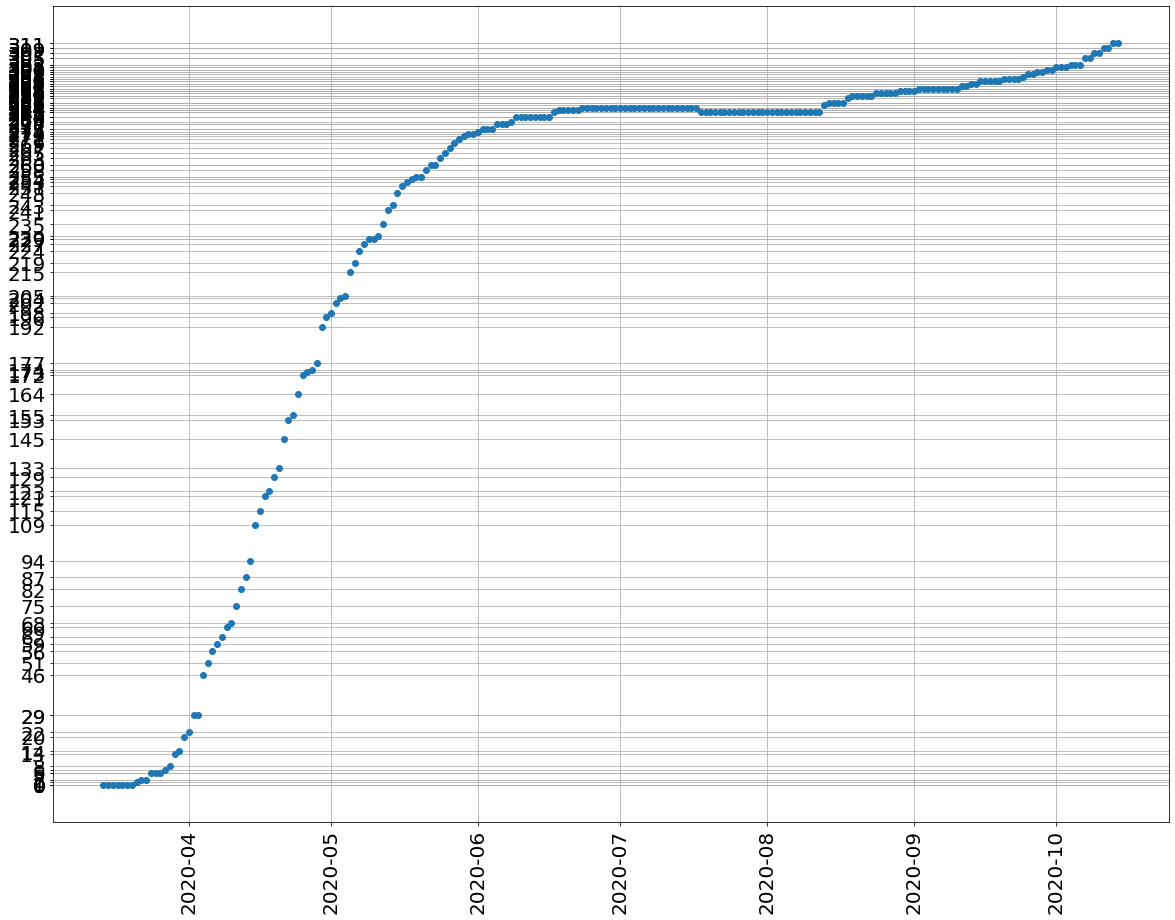

      Date_of_report  Deceased
476       2020-03-14         0
843       2020-03-15         0
1210      2020-03-16         0
1577      2020-03-17         0
1944      2020-03-18         0
...              ...       ...
77546     2020-10-10       307
77913     2020-10-11       309
78280     2020-10-12       309
78647     2020-10-13       311
79014     2020-10-14       311

[215 rows x 2 columns]


In [14]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Deceased")